# Восстановление золота из руды

Компания, занимающаяся разработкой решений для эффективной работы промышленных предприятий, старается оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Задача**
Необходимо подготовить модель машинного обучения, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды, что поможет оптимизировать производство.

**Входные данные**

Предстоит работа с данными, содержащими параметры добычи и очистки золотосодержащей руды.

**План**

1. Предобработка и подготовка данных.
0. Исследовательский анализ данных.
0. Обучение и анализ моделей.

## Подготовка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

from tqdm import tqdm

In [2]:
SEED = 66

In [3]:
try:
    df_train = pd.read_csv('gold_recovery_train_new.csv')
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [4]:
try:
    df_test = pd.read_csv('gold_recovery_test_new.csv')
except:
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [5]:
try:
    df_full = pd.read_csv('gold_recovery_full_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [6]:
for df in [df_train, df_test, df_full]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Есть пропуски. В тестовой выборке меньше столбцов. Будем решать данные проблемы. Но для начала проверим, насколько верное указано значение `rougher.output.recovery` в обучающей выборке.

In [7]:
def recovery(df):
    C = 'rougher.output.concentrate_au'
    F = 'rougher.input.feed_au'
    T = 'rougher.output.tail_au'
    return 100 * (df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T]))

In [8]:
df_train_check = df_train.dropna(subset=['rougher.output.concentrate_au',
                                         'rougher.input.feed_au',
                                         'rougher.output.tail_au'])

In [9]:
mean_absolute_error(df_train_check['rougher.output.recovery'], recovery(df_train_check))

1.1131451184435918e-14

МАЕ между расчётным и указанным значениями recovery мала, значит значения практически не различаются.

Рассмотрим столбцы, которые не представлены в тестовой выборке.

In [10]:
list(set(df_train.columns) - set(df_test.columns))

['rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'rougher.output.recovery',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'final.output.concentrate_au',
 'rougher.calculation.au_pb_ratio',
 'final.output.tail_sol',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.concentrate_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_pb',
 'final.output.tail_ag',
 'final.output.recovery',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.tail_ag',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.tail_sol',
 'final.output.concentrate_ag',
 'final.output.tail_au',
 'rougher.output.tail_au',
 'primary_cleaner.output.concentrate_pb',
 'primar

В тестовой выборке отсутствуют данные о выходных и рассчётных параметрах. Это объясняется тем, что некоторые параметры замеряются и/или рассчитываются значительно позже. Также в выборке отсутствуют целевые признаки, которые можно попробовать восстановить из общей таблицы (или же рассчитать по формуле, т.к. выше мы выяснили, что значения окажутся достаточно точными).

Т.к. в тестовом наборе не хватает некоторых данных, следовательно, обучать модели будем только на тех столбцах обучающей выборки, которые есть в тестовой. Подготовим данные для дальнейшей работы.

In [11]:
# проверим количество пропусков
df_train.isna().sum() / df_train.shape[0]

date                                          0.000000
final.output.concentrate_ag                   0.000071
final.output.concentrate_pb                   0.000071
final.output.concentrate_sol                  0.014913
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.000071
secondary_cleaner.state.floatbank5_b_air      0.000071
secondary_cleaner.state.floatbank5_b_level    0.000071
secondary_cleaner.state.floatbank6_a_air      0.000141
secondary_cleaner.state.floatbank6_a_level    0.000071
Length: 87, dtype: float64

Пропусков довольно много, заполним их.

In [12]:
df_train.fillna(method='ffill', inplace=True)

Перейдём к тестовой выборке.

In [13]:
# проверим количество пропусков
df_test.isna().sum() / df_test.shape[0]

date                                          0.000000
primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol                        0.003970
rougher.in

Пропусков довольно мало, удалим строки с пропущенными значениями.

In [14]:
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5229 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5229 non-null   object 
 1   primary_cleaner.input.sulfate               5229 non-null   float64
 2   primary_cleaner.input.depressant            5229 non-null   float64
 3   primary_cleaner.input.feed_size             5229 non-null   float64
 4   primary_cleaner.input.xanthate              5229 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5229 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5229 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5229 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5229 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5229 non-null   float64
 10  primary_clea

Перейдём к анализу данных.

## Анализ данных

Исследуем, как изменяется концентрация металлов на различных этапах очистки.

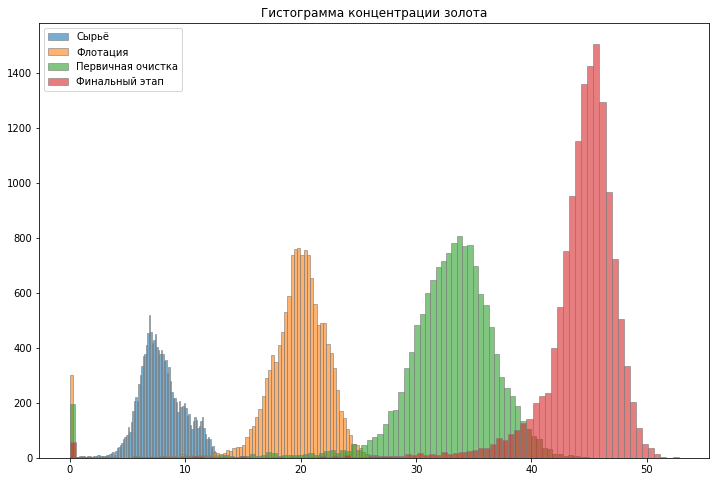

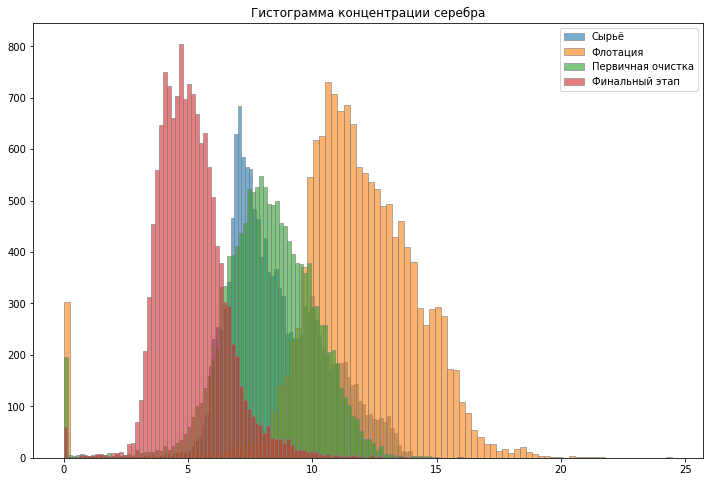

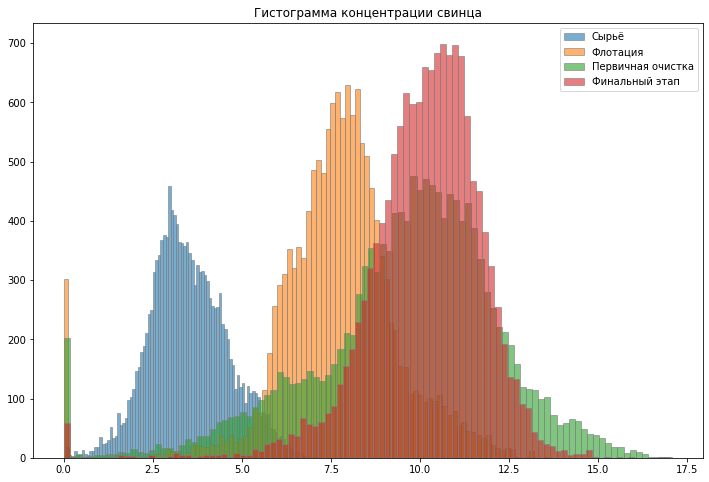

In [15]:
for metal, name in {'au':'золота', 'ag':'серебра', 'pb':'свинца'}.items():
    plt.figure(figsize=(12,8))
    for col, stage in {f'rougher.input.feed_{metal}':'Сырьё',
                       f'rougher.output.concentrate_{metal}':'Флотация',
                       f'primary_cleaner.output.concentrate_{metal}':'Первичная очистка',
                       f'final.output.concentrate_{metal}':'Финальный этап'}.items():
        plt.hist(df_train[col], bins=100, edgecolor='grey', alpha=0.6, label=stage, density=False)
    plt.legend()
    plt.title(f'Гистограмма концентрации {name}')
    plt.show()

Из построенных гистограмм видно, как по-разному меняются концентрации веществ от этапа к этапу. Например, концентрация золота постоянно возрастает. Концентрация свинца вплоть до первичной очистки так же растёт, однако на выходе концентрация остаётся прежней относительно предыдущего этапа. Концентрация серебра сначала увеличивается на этапе флотации, а затем падает.

Сравним распределение размеров гранул сырья на обучающей и тестовой выборках.

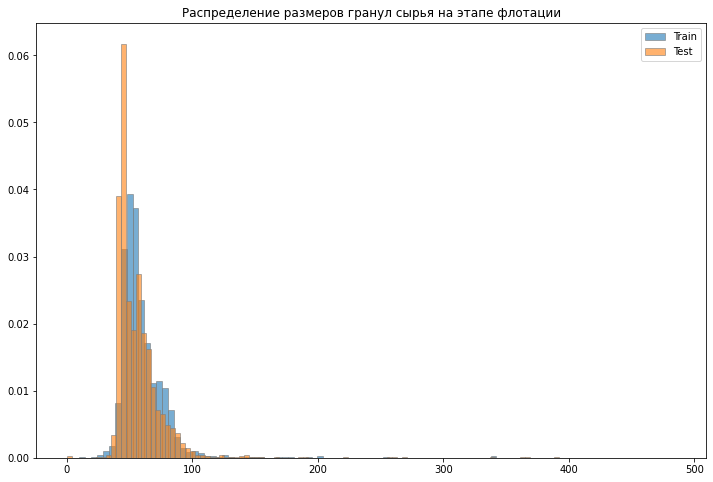

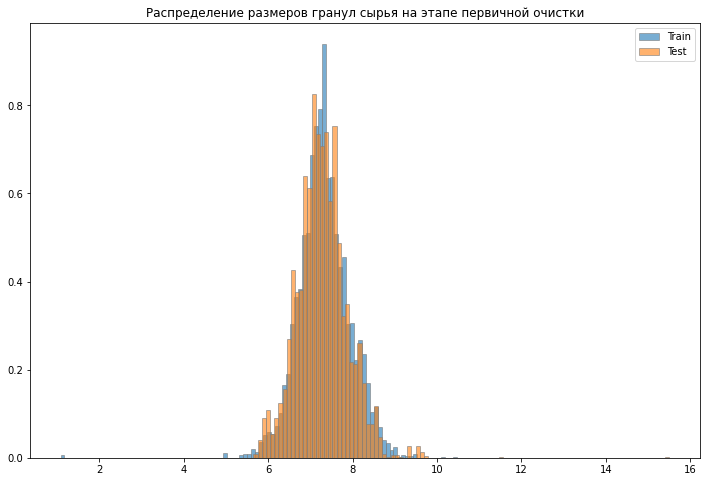

In [16]:
param = '.input.feed_size'
for stage, name in {'rougher':'флотации', 'primary_cleaner':'первичной очистки'}.items():
    plt.figure(figsize=(12,8))
    plt.hist(df_train[f'{stage}{param}'], bins=100, edgecolor='grey',
             alpha=0.6, label='Train', density=True)
    plt.hist(df_test[f'{stage}{param}'], bins=100, edgecolor='grey',
             alpha=0.6, label='Test', density=True)
    plt.legend()
    plt.title(f'Распределение размеров гранул сырья на этапе {name}')
    plt.show()

В целом видим, что распределения на двух выборках похожи.

Исследуем также суммарную концентрацию всех веществ на разных стадиях.

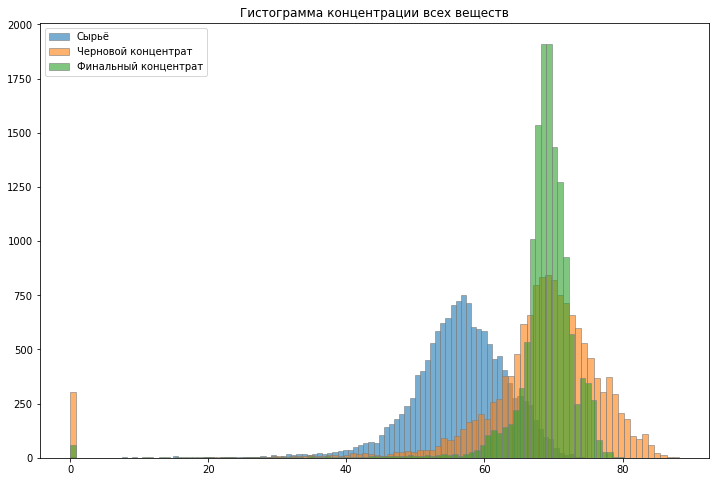

In [17]:
stages = {'rougher.input.feed_':'Сырьё',
          'rougher.output.concentrate_':'Черновой концентрат',
          'final.output.concentrate_':'Финальный концентрат'}
for stage in stages.keys():
    df_train[stage] = (df_train[f'{stage}au'] + df_train[f'{stage}ag'] +
                       df_train[f'{stage}pb'] + df_train[f'{stage}sol'])

plt.figure(figsize=(12,8))
for stage, name in stages.items():
    plt.hist(df_train[stage], bins=100, edgecolor='grey', alpha=0.6, label=name, density=False)
plt.legend()
plt.title(f'Гистограмма концентрации всех веществ')
plt.show()

Видим, что на этапе флотации суммарная концентрация веществ увеличивается. В ходе дальнейшей очистки концентрация в среднем остаётся примерно той же.

Также видим, что встречается ситуация, когда концентрация всех веществ оказывается равна 0. Такое вряд ли возможно, поэтому удалим такие строки и скорректируем наши выборки.

In [18]:
df_train = df_train[(df_train['rougher.input.feed_'] != 0) &
                    (df_train['rougher.output.concentrate_'] != 0) &
                    (df_train['final.output.concentrate_'] != 0)]

Подготовим данные для обучения.

In [19]:
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery',
                                 'final.output.recovery']],
                        on='date', how='left')
target_test = df_test[['rougher.output.recovery', 'final.output.recovery']]
features_test = df_test.drop(['date', 'rougher.output.recovery',
                              'final.output.recovery'], axis=1)

In [20]:
target_train = df_train[['rougher.output.recovery',
                         'final.output.recovery']]
features_train = df_train[features_test.columns]

## Модель

Реализуем необходимую метрику.

In [21]:
def smape(target, predicted):
    return sum(100 * 2 * abs(target - predicted) /
               (abs(target) + abs(predicted))) / len(target)

In [22]:
def total_smape(target, predicted):
    rougher_name = 'rougher.output.recovery'
    final_name = 'final.output.recovery'
    rougher_smape = smape(target[rougher_name], predicted[:, 0])
    final_smape = smape(target[final_name], predicted[:, 1])
    return 0.25 * rougher_smape + 0.75 * final_smape

In [23]:
scorer = make_scorer(total_smape, greater_is_better=False)

Перейдём к обучению моделей.

In [24]:
lr_result = cross_val_score(LinearRegression(), features_train, target_train, scoring=scorer)
print('LinearRegression')
print(f'sMAPE = {abs(lr_result.mean()):.5f}')

LinearRegression
sMAPE = 10.05960


In [25]:
%%time

dt_params = {'max_depth':list(range(2, 11)),
             'min_samples_leaf':list(range(2, 11))}
dt_search = RandomizedSearchCV(DecisionTreeRegressor(random_state=SEED),
                               dt_params, scoring=scorer, n_jobs=-1,
                               random_state=SEED)
dt_search.fit(features_train, target_train)

print('DecisionTreeRegressor')
print(f'sMAPE = {abs(dt_search.best_score_):.5f} '
      f'при параметрах {dt_search.best_params_}\n')
print()

DecisionTreeRegressor
sMAPE = 9.17418 при параметрах {'min_samples_leaf': 8, 'max_depth': 3}


CPU times: user 23.2 s, sys: 5.29 ms, total: 23.2 s
Wall time: 24 s


In [26]:
%%time

rf_params = {'n_estimators':list(range(2, 11)),
             'max_depth':list(range(2, 11))}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=SEED),
                               rf_params, scoring=scorer, n_jobs=-1,
                               random_state=SEED)
rf_search.fit(features_train, target_train)

print('RandomForestRegressor')
print(f'sMAPE = {abs(rf_search.best_score_):.5f} '
      f'при параметрах {rf_search.best_params_}\n')
print()

RandomForestRegressor
sMAPE = 8.94712 при параметрах {'n_estimators': 8, 'max_depth': 3}


CPU times: user 1min 43s, sys: 168 ms, total: 1min 43s
Wall time: 1min 47s


Лучший результат дала модель RandomForestRegressor с параметрами n_estimators = 8 и max_depth = 3. Проверим модель на тестовой выборке.

In [27]:
rf_search.best_estimator_.fit(features_train, target_train)
predicted = rf_search.best_estimator_.predict(features_test)
print(f'Test sMAPE = {total_smape(target_test, predicted):.5f}')

Test sMAPE = 8.61766


Результат не стал хуже. Сравним его с результатом на константной модели. 

In [28]:
target_median = target_test[['rougher.output.recovery',
                              'final.output.recovery']]
for col in target_median.columns:
    target_median[col] = target_train[col].median()
print(f'Constant sMAPE = {total_smape(target_test, target_median.to_numpy()):.5f}')

Constant sMAPE = 9.01009


Построенная модель оказалась несколько лучше константной, проверка на адекватность пройдена.

## Вывод

На первом шаге были загружены данные. Сначала проведена общая обработка: заполнены или удалены имеющиеся пропуски, рассмотрены причины различия данных в датасетах, проверено соответствие указанного заначения эффективности обогащения рассчётному.

Затем был проведён анализ имеющихся данных. Рассмотрены изменения концентрации веществ от этапа к этапу (например, концентрация золота растёт с каждым этапом, что вполне логично - рассмотрен процесс обогащения). Проверены распределения размеров гранул в обучающей и тестовой выборках: т.к. распределения похожи, это даёт возможность далее обучать модели. Также была проверена суммарная концентрация веществ на различных этапах. Обнаруженная аномалия - нулевая концентрация - устранена.

Перед обучением модели были подготовлены данные - из обучающей выборки выделены целевые признаки и удалены признаки, которые отсутствуют в тестовой выборке. 

Были обучены несколько моделей регрессии. Полученные результаты:

 - *LinearRegression*: `sMAPE = 10.05960`;
 - *DecisionTreeRegressor*: `sMAPE = 9.17418` при `max_depth = 3` и `min_samples_leaf = 8`;
 - *RandomForestRegressor*: `sMAPE = 8.94712` при `n_estimators = 8` и `max_depth = 3`.
 
Лучшей моделью оказался случайный лес с 10 деревьями глубины 3. Модель была проверена на тестовой выборке: `Test sMAPE = 8.61766`. Для проверки адекватности построенной модели была расчитана метрика на константной модели: `Constant sMAPE = 9.01009`. Т.е. построенная модель оказалась несколько лучше константной.